# Question 2: Unsupervised learning, clustering problem
In this file, we will try to cluster the data *CrowdstormingDataJuly1st.csv* into 2 clusters. We will see if it is possible to find a set of attributes such that the 2 clusters clearly separate black from white players. We will:
1. Preprocess the dataset so that the attributes are the one we need in the way we want. More specifically, we will aggregate the dataset grouping by players, and keep (or transform) only the information that concern the player or the relation player-referees, but we will not keep any infomation about the referees alone.
2. We will cluster the whole dataset with KMeans++ and see what we get.
3. We will choose recursively some attributes in a supervised way (that is using the evaluation of the 2 raters about the skin color of each player), and look at the evolution of the result of KMeans++.
4. We will choose recursively some attributes in a full unsupervised way, and look at the evolution of the result of KMeans++.

## Dataset importation
At first, we import the dataset in csv format and perform an essential exploration of its features.

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load data
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
print(data.columns)
data.head()

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Pre-processing of the data

Since some labels are missing, we will only consider the players with both ratings, for the training dataset. We will also see that there are no players with a single rating missing.

In [3]:
missing_rater_data=data[data.rater2.isnull() & data.rater1.isnull()]
rater_data=data[data.rater2.notnull() & data.rater1.notnull()]

In [4]:
data_one_rater2 = data[data.rater2.isnull() & ~data.rater1.isnull()]
data_one_rater1 = data[data.rater1.isnull() & ~data.rater2.isnull()]
print('There are '+str(len(data_one_rater2)+len(data_one_rater1))+
      ' player(s) with a single rating missing.')
print('Out of '+str(data.shape[0])+' data entries, we will only consider '+
      str(rater_data.shape[0])+' of them, i.e. '+str(rater_data.shape[0]*
                                                        100/data.shape[0])
      +'% of the entries, because of '+str(missing_rater_data.shape[0])+
      ' entries for which the skin color has not been rated.')

There are 0 player(s) with a single rating missing.
Out of 146028 data entries, we will only consider 124621 of them, i.e. 85.34048264716355% of the entries, because of 21407 entries for which the skin color has not been rated.


In this preprocessing step, we will:
- Delete the column photoID
- Delete all the rows corresponding to a referee with less than 22 entry (indeed, this is impossible to have a referee with less than 22 entries, that corresponds to the number of players in two teams, that is the minimum number of players necessary for one game). This is done in function preprocess_1
- Remove the less significant referee entry, that is the entries with an nIAT and an nExp too low). This is done in function preprocess_2

In [5]:
def preprocess_1(database,remove_bad_referee=True,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    del train['photoID']
    
    train_group=train.groupby(train.refNum)
    
    if remove_bad_referee:
        for i,group in train_group:
            if group.shape[0]<22:
                train=train.drop(train_group.get_group(i).index)
            if i%500==0:
                print(i)
    
   
    return train

In [6]:
train_after_prep_1=preprocess_1(rater_data,remove_bad_referee=True)

500
1000
1500
2000
2500
3000


In [7]:
def preprocess_2(database,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    train_group=database.groupby(train.refNum)

    for i,group in train_group:
        if group.nIAT.iloc[0]<nIAT_threshold or group.nExp.iloc[0]<nExp_threshold:
            train=train.drop(train_group.get_group(i).index)
        if i%200==0:
            print(i)
    return train

In [8]:
train_after_prep_2=preprocess_2(train_after_prep_1)

1600
2400
3000


In [9]:
print('After the 2 preprocessing steps, '+str(train_after_prep_2.shape[0])
      +' of the entries remain, that is '+str(train_after_prep_2.shape[0]*100
                                              /rater_data.shape[0])+'% of them.')

After the 2 preprocessing steps, 111533 of the entries remain, that is 89.49775719982989% of them.


We normalize the number of victories, ties, defeats, goals, yellowCards, redCards and yellowReds by the number of games done with each referee, for the data to be comparable. To do so, we just quickly check that no dyad (player,referee) has a total number of games played together of 0. And then we delete the 'games' column that is not important anymore. 

In [10]:
entries = ['victories','ties','defeats','goals','yellowCards','yellowReds','redCards']
data_clean = pd.DataFrame()
print(train_after_prep_2[train_after_prep_2['games']==0].shape[0], 
      'dyad (player,referee) have a null total number of games played together.')

0 dyad (player,referee) have a null total number of games played together.


In [11]:
for ent in entries:
    train_after_prep_2[ent] = train_after_prep_2[ent]/train_after_prep_2.games
entries.append('games')
train_after_prep_2[entries].head(10)

,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,games
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,1.0,0.0,0.0,0.0,0.5,0.0,0.0,2
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [12]:
del train_after_prep_2['games']
del train_after_prep_2['player']

We have also deleted the 'player' column since it is in bijection with the playerShort name. We will now remove the nan values by filling NaN with median of the columns or with 'nan' if it is a categorical variable. 

In [13]:
train = train_after_prep_2
train.position=train.position.fillna('nan')

In [14]:
train.leagueCountry=train.leagueCountry.fillna('nan')

In [15]:
train=train.fillna(train.median())

In this way, we should not have any nan value anymore now, so that if we are carefull enough, we should not have to deal with NaNs anymore in the following.

In [16]:
print(len(train[train.meanExp.isnull()]), 'NaN value(s) left in meanExp.')
print(len(train[train.meanIAT.isnull()]), 'NaN value(s) left in meanIAT.')

0 NaN value(s) left in meanExp.
0 NaN value(s) left in meanIAT.


In [17]:
summ = 0
for col in train.columns:
    summ = summ+train[train[col].isnull()].shape[0]
print('There are',summ, 'NaN value(s) left in our dataframe.')

There are 0 NaN value(s) left in our dataframe.


We keep only the year of birth (not the date), and we transorm it into an int.

In [18]:
train.birthday=train.birthday.apply(lambda x: int(x.split('.')[2]))

Now, we notice that the IAT and the Exp are here to identify how much can a referee be racist. In order to only keep information about the player itself, or the relation between the player and the referee, we choose to ponderate the yellowCards, redCards and yellowReds by the IAT and the Exp. This is indeed in the way to prepare the group_by player.

In [19]:
train['IAT_yellow']=train.yellowCards*train.meanIAT
train['IAT_red']=train.redCards*train.meanIAT
train['Exp_yellow']=train.yellowCards*train.meanExp
train['Exp_red']=train.redCards*train.meanExp
train['ITA_yellowred']=train.yellowReds*train.meanIAT
train['Exp_yellowred']=train.yellowReds*train.meanExp

Now, we delete the unwanted and unnecessary columns, i.e. the ones that give information only on the referee.

In [20]:
train = train.drop(['meanIAT','nIAT','seIAT','meanExp','nExp','seExp','refCountry',
                    'refNum','Alpha_3'], axis=1)

In [21]:
train.head(5)

,playerShort,club,leagueCountry,birthday,height,weight,position,victories,ties,defeats,...,yellowReds,redCards,rater1,rater2,IAT_yellow,IAT_red,Exp_yellow,Exp_red,ITA_yellowred,Exp_yellowred
5,aaron-hughes,Fulham FC,England,1979,182.0,71.0,Center Back,0.0,0.0,1.0,...,0.0,0.0,0.25,0.00,0.0,0.0,0.0,0.0,0.0,0.0
6,aleksandar-kolarov,Manchester City,England,1985,187.0,80.0,Left Fullback,1.0,0.0,0.0,...,0.0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0
7,alexander-tettey,Norwich City,England,1986,180.0,68.0,Defensive Midfielder,0.0,0.0,1.0,...,0.0,0.0,1.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0
8,anders-lindegaard,Manchester United,England,1984,193.0,80.0,Goalkeeper,0.0,1.0,0.0,...,0.0,0.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0
9,andreas-beck,1899 Hoffenheim,Germany,1987,180.0,70.0,Right Fullback,1.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
short_data = train_after_prep_2[['playerShort','position']]
print('There are ', len(short_data[short_data.columns[short_data.iloc[0] 
                                                      == short_data.iloc[1]]].columns),
      'player(s) playing in two different positions.')
short_data = train_after_prep_2[['playerShort','club']]
print('There are ', len(short_data[short_data.columns[short_data.iloc[0] 
                                                      == short_data.iloc[1]]].columns),
      'player(s) playing in two different clubs.')

There are  0 player(s) playing in two different positions.
There are  0 player(s) playing in two different clubs.


This last information is some good news! It means that when we will group the data by players, we will not have to take too much care of the 'position' field nor the 'club' field since the function mapping the player to its position is well defined.

Some more operations in the data are done in the following:

- Add dummy variables for the categorical variables so that each cell has equal importance and there is no ordering issue between the categories.
- Keep one entry for each player (i.e. group_by player)
- Normalize all the entries to have numbers between 0 and 1, so that all fields have equal importance in the clustering
- Extract the mean of the rater1 and rater2 to get a new field skinColor and delete rater1 and rater2 columns

In [23]:
train.columns

Index(['playerShort', 'club', 'leagueCountry', 'birthday', 'height', 'weight',
       'position', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'rater1', 'rater2', 'IAT_yellow', 'IAT_red',
       'Exp_yellow', 'Exp_red', 'ITA_yellowred', 'Exp_yellowred'],
      dtype='object')

1- Replace string attributes by dummies variables

In [24]:
dumm=pd.get_dummies(train[['position','leagueCountry','club']])

In [25]:
train=pd.concat([train,dumm],axis=1)

In [26]:
del train['leagueCountry']
del train['position']
del train['position_nan']

In [27]:
train.columns

Index(['playerShort', 'club', 'birthday', 'height', 'weight', 'victories',
       'ties', 'defeats', 'goals', 'yellowCards',
       ...
       'club_Valencia CF', 'club_Valenciennes FC', 'club_VfB Stuttgart',
       'club_VfL Wolfsburg', 'club_Werder Bremen', 'club_West Bromwich Albion',
       'club_West Ham United', 'club_Wigan Athletic',
       'club_Wolverhampton Wanderers', 'club_Évian Thonon Gaillard'],
      dtype='object', length=132)

2- Aggregation: group by players.

In [28]:
train=train.groupby('playerShort').mean()

In [29]:
train.head()

,birthday,height,weight,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,club_Valencia CF,club_Valenciennes FC,club_VfB Stuttgart,club_VfL Wolfsburg,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,0.430823,0.251705,0.317472,0.012870,0.036590,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,1986,183.0,73.0,0.470884,0.207979,0.321136,0.132798,0.093665,0.000000,0.000818,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,1987,165.0,63.0,0.524169,0.231699,0.244132,0.048311,0.018085,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-ramsey,1990,178.0,76.0,0.554130,0.163463,0.282407,0.200943,0.128526,0.000000,0.010417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,1990,180.0,73.0,0.313798,0.293912,0.392290,0.004082,0.065748,0.043129,0.011429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3- Normalize entries to equalize the importance of each attribute.

In [30]:
for col in train.columns:
    train[col] = (train[col]-train[col].min())/train[col].max()

4- Extract the mean of the skin colors given by the two raters.

In [31]:
train['skinColor']=(train['rater1']+train['rater2'])/2
del train['rater1']
del train['rater2']

In [32]:
train.head()

,birthday,height,weight,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,club_Valenciennes FC,club_VfB Stuttgart,club_VfL Wolfsburg,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard,skinColor
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.004008,0.103448,0.17,0.430823,0.251705,0.317472,0.017891,0.036590,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125
aaron-hunt,0.007515,0.108374,0.19,0.470884,0.207979,0.321136,0.184604,0.093665,0.000000,0.004910,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.125
aaron-lennon,0.008016,0.019704,0.09,0.524169,0.231699,0.244132,0.067158,0.018085,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250
aaron-ramsey,0.009519,0.083744,0.22,0.554130,0.163463,0.282407,0.279333,0.128526,0.000000,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
abdelhamid-el-kaoutari,0.009519,0.093596,0.19,0.313798,0.293912,0.392290,0.005674,0.065748,0.646939,0.068571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250


## Data analysis: clustering
Choices done:
* Choice of the algorithm: KMeans.
* Choice of 'init' parameter of KMeans: use of KMeans++.
* Choice of the features to iterately remove, and in which order (in particular, with or without the rater's means).

In [33]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from time import time

In [34]:
labels = 1*(train.skinColor>=0.5) # reference on the labels we should get if the 
# clustering were separating blacks from whites. 

The following function `estimate_data` runs the fitting of some estimator algorithm (for our exercise it will always be KMeans) and can print the silhouette score obtained, together with the time it takes to run it. 

In [35]:
def estimate_data(estimator, metric, name, data, printit):
    t0 = time()
    estimator.fit(data)
    silh_score = metrics.silhouette_score(data, estimator.labels_, metric=metric)
    if(printit):
        print('% 9s   %.2fs    %.3f'
               % (name, (time() - t0), silh_score))
    return silh_score

Let us compare KMeans if we take 'k-means++' or 'random' as `init` parameters. 

In [36]:
metric_silhouette = 'euclidean'
kmpp = KMeans(init='k-means++', n_clusters=2)
km_rand = KMeans(init='random', n_clusters=2)

s1 = estimate_data(kmpp,metric_silhouette,'k-means++ euclidean   ',train,True)
s2 = estimate_data(km_rand,metric_silhouette,'k-means rand euclidean',train,True)

k-means++ euclidean      0.50s    0.109
k-means rand euclidean   0.47s    0.109


We notice that both silhouettes are equal and not very high at all. This means that the two clusters have a high overlap, i.e. they are not so well distinct. Indeed, we have a high number of attributes, that is a high dimensionality of our problem, so that it is harder for the algorithm to find clear separate clusters. Moreover, lots of data do not cluster the players into only 2 clusters, but into more clusters (ex: by club, by country, etc.)

The two algorithms performing equally well, we will choose in the following to use KMeans++ even if it seems a bit slower.

Let us see how this (low quality) clustering has separated blacks into white, by computing the mean of the "skinColor" values in each cluster. The more different is the mean (i.e. one cluster's value tending to 1 -the blacks-, the other one's tending to 0 -the whites-), the better the clustering has performed to separate blacks and whites. 

In [37]:
train0 = train[kmpp.labels_==0]
train1 = train[kmpp.labels_==1]
print('The mean color skin factor of cluster 1 is equal to', train0.skinColor.mean())
print('The mean color skin factor of cluster 2 is equal to', train1.skinColor.mean())
print('The total mean color skin is equal to', train.skinColor.mean(), 
      'if it is represented by steps of 0.25, or is equal to', labels.mean(), 
      'if it is represented as a binary value, with the threshold at 0.5.')

The mean color skin factor of cluster 1 is equal to 0.3257918552036199
The mean color skin factor of cluster 2 is equal to 0.20589770354906053
The total mean color skin is equal to 0.28953598484848486 if it is represented by steps of 0.25, or is equal to 0.24305555555555555 if it is represented as a binary value, with the threshold at 0.5.


We can see that the mean is slightly different in both cases, and is very close to the total mean skin color. This means that the two clusters have not been determined with respect to the skin color (or only slightly), but mostly with respect to some other factors. It is normal that both means tend to be closer to 0 than to 1 since the total mean skin color is of 0.28 (that is, there are globally 2/3 of whites and only 1/3 of blacks, considering the threshold at skinColor = 0.5).

We first collect the column labels and then class them by increasing order of importance with respect to our goal, that is see if we are able to cluster whites and blacks. All of that is done in order to be able to take the attributes out of the analysis one by one.

We expect that the less attributes and the more specific they are for our problem, the better will be the sihouette score, and the further apart will be the means of the two clusters, meaning that we are more able to differentiate blacks and whites. 

## First way to solve the problem
### Supposing we have the rater's evaluation of the skin color of the players:

The importance ordering can obviously be controversed, and it influences a lot the clustering. Since our goal is to separate blacks from whites, we will plot the mean of each of the attributes for both blacks and whites, and see for which attributes it differs the most. The more it differs, the more "important" are the attributes to discriminate blacks and whites. 

Note that it is a "semi-supervised" way to cluster the data since we have a partial (and controversal) idea of the skin color of each player, and we use it to choose the attributes. The choice of the attributes is thus the supervised part, and consequently we have to separate our data into training and testing samples, and perform a cross-validation. However, once the attributes are chosen, we perform a KMeans++ algorithm (fully unsupervised) to cluster our data. We will show in the next part a full unsupervised way to choose the attributes AND to cluster the data.

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The following step can be performed only because we have the information about the skin color given by the raters. To be even more reliable, we would need more raters, but we will proceed anyway with only 2 raters. For the reason said earlier, we first split into training and testing sets.

In [39]:
from sklearn.cross_validation import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.4, random_state=4)

We group by skin color, computing the mean of each attribute for each skin color.

In [41]:
train4plot = X_train.copy()
train4plot['binarySkinColor'] = labels
train4plot = train4plot.groupby('binarySkinColor').mean()
train4plot

,birthday,height,weight,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,club_Valenciennes FC,club_VfB Stuttgart,club_VfL Wolfsburg,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard,skinColor
binarySkinColor,,,,,,,,,,,,,,,,,,,,,
0,0.007321,0.104206,0.220705,0.445831,0.233063,0.321106,0.137171,0.135360,0.067926,0.025996,...,0.002821,0.019746,0.028209,0.023977,0.015515,0.002821,0.008463,0.000000,0.007052,0.150212
1,0.007631,0.101098,0.217220,0.418145,0.245908,0.335947,0.147282,0.120721,0.060205,0.029125,...,0.012448,0.024896,0.004149,0.008299,0.012448,0.020747,0.020747,0.004149,0.008299,0.744813


We plot the mean of each attribute for each binary skin color to see the difference between them.

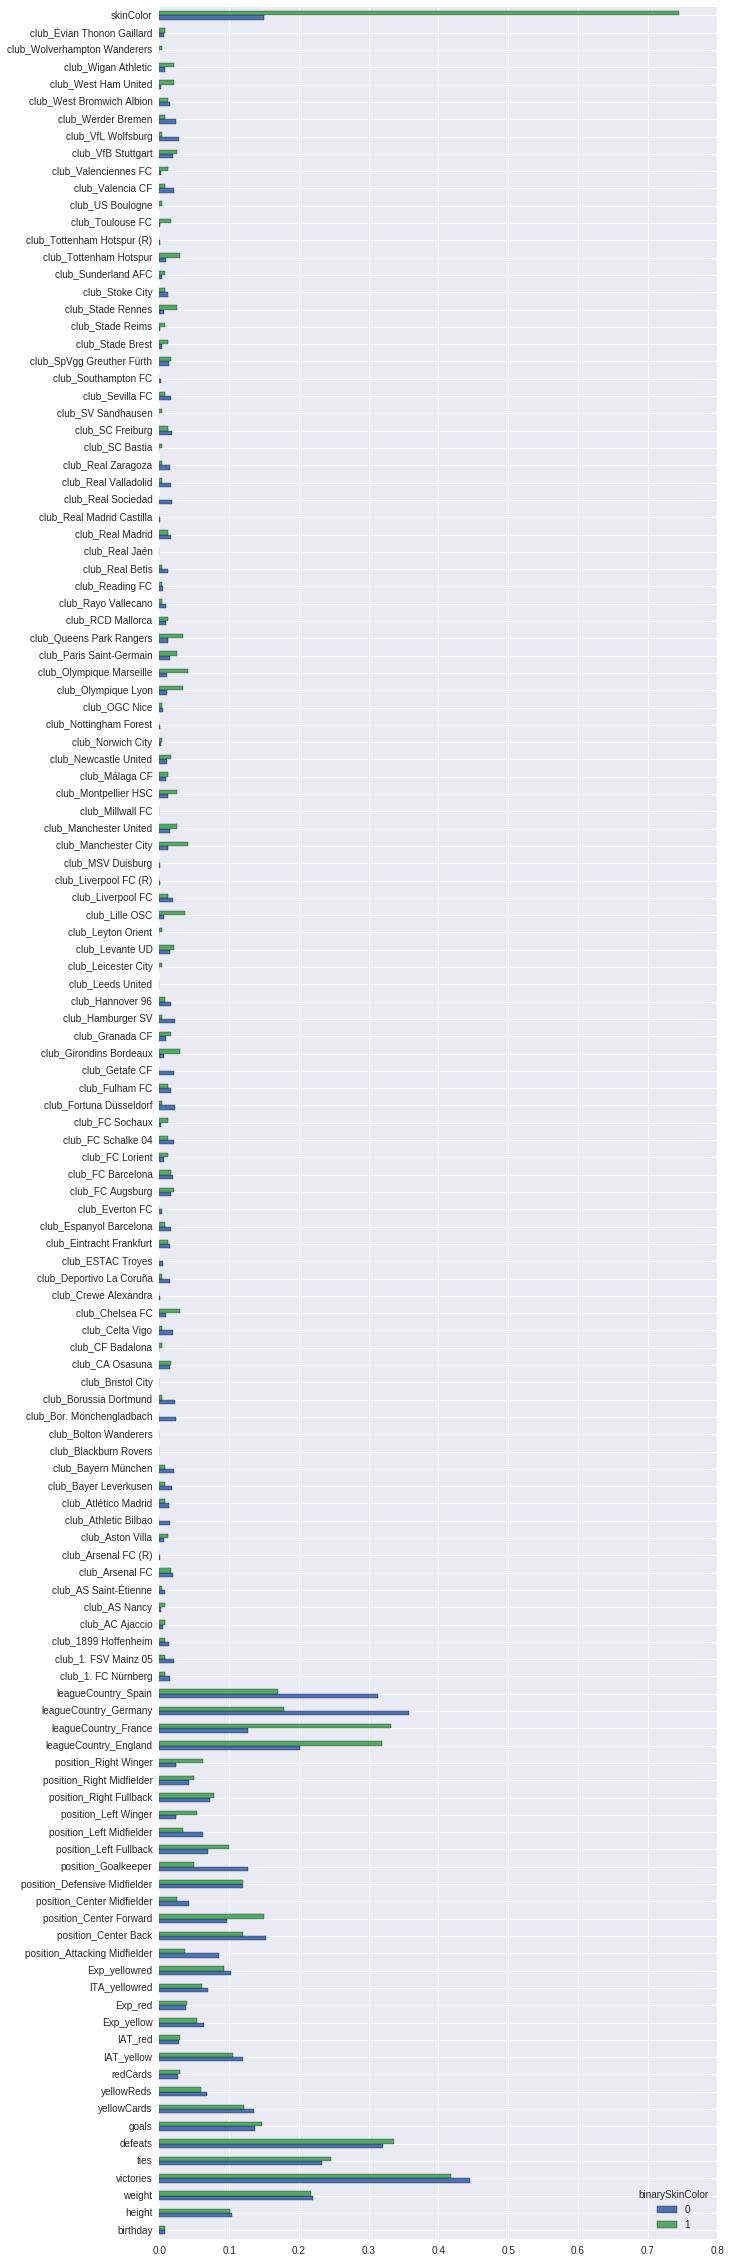

In [42]:
train4plot.T.plot(kind='barh',figsize=(10,40))

We easily see that the clear most relevant feature is the skin color, which is absolutely obvious. We now have to order them from the lowest difference to the highest, that is from the less relevant attribute to the most relevant one.

In [43]:
train_ordered = train4plot.diff(axis=0).abs()
train_ordered = train_ordered.iloc[1,:].sort_values()
print(train_ordered.head())
print(train_ordered.tail())

club_Millwall FC         0.0
club_Blackburn Rovers    0.0
club_Bristol City        0.0
club_Bolton Wanderers    0.0
club_Leeds United        0.0
Name: 1, dtype: float64
leagueCountry_England    0.117810
leagueCountry_Spain      0.142993
leagueCountry_Germany    0.179828
leagueCountry_France     0.205011
skinColor                0.594602
Name: 1, dtype: float64


The index of train_ordered is ordered in increasing order of importance of the attributes.

In [44]:
ordered_attributes = train_ordered.index
ordered_attributes

Index(['club_Millwall FC', 'club_Blackburn Rovers', 'club_Bristol City',
       'club_Bolton Wanderers', 'club_Leeds United', 'club_Real Jaén',
       'birthday', 'position_Defensive Midfielder', 'club_CA Osasuna',
       'club_Évian Thonon Gaillard',
       ...
       'position_Center Back', 'position_Right Winger',
       'position_Attacking Midfielder', 'position_Center Forward',
       'position_Goalkeeper', 'leagueCountry_England', 'leagueCountry_Spain',
       'leagueCountry_Germany', 'leagueCountry_France', 'skinColor'],
      dtype='object', length=129)

Note that we should do a K-fold cross-validation on this result, and then take a global best ordering that is a compromise between all found ordering. Since this part of the homework was not strictly required, we will not do it, estimating that the ordering found is already a good a representative one. We are however conscious that it could be improved.

In the following, we thus perform the KMeans++ clustering algorithm on the dataset, throwing away iteratively the first attribute, so that at the end we are left with only the most relevant one. We hope that at some point, the clustering separates quite accurately blacks from whites. To know if it does, we perform the same test as before, computing the mean of the skinColors of both clusters. The closer to 0 it is, the more whites there are in the cluster. The closer to 1 it is, the more blacks there are in the cluster. 

In [45]:
scores = []
mean0 = []
mean1 = []
for i in range(0,len(ordered_attributes)):
    scores.append(
        estimate_data(kmpp,metric_silhouette,'k-means++ euclidean  ',
                      X_test[ordered_attributes[i:]], False))
    mean0.append(y_test[kmpp.labels_==0].mean())
    mean1.append(y_test[kmpp.labels_==1].mean())

We now plot the evolution of the silhouette score with respect to the number of attributes left.

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

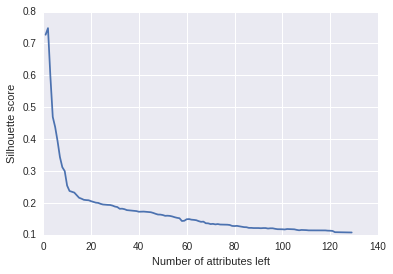

In [47]:
plt.plot(range(len(ordered_attributes),0,-1), scores)
plt.xlabel('Number of attributes left')
plt.ylabel('Silhouette score')

We see that the less attributes we have, the best is the silhouette score, that is the better the 2 found clusters are separated. There is in particular a strong angle around  a number of attributes left equal to 10. This means that the following 10 attributes allow us better to separate the data into 2 clusters:

In [48]:
ordered_attributes[-10:]

Index(['position_Center Back', 'position_Right Winger',
       'position_Attacking Midfielder', 'position_Center Forward',
       'position_Goalkeeper', 'leagueCountry_England', 'leagueCountry_Spain',
       'leagueCountry_Germany', 'leagueCountry_France', 'skinColor'],
      dtype='object')

But once we have two "clear" clusters, do those clusters separate blacks from whites, as we have tried to influence, or not?

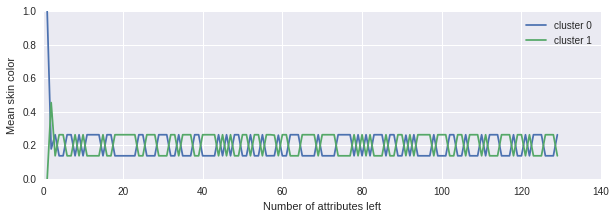

In [49]:
fig,ax = plt.subplots(figsize=(10,3))
plt.plot(range(len(ordered_attributes),0,-1), mean0, label='cluster 0')
plt.plot(range(len(ordered_attributes),0,-1), mean1, label='cluster 1')
plt.xlabel('Number of attributes left')
plt.ylabel('Mean skin color')
ax.legend()

Let's make a zoom on the end of the loop, that is when just few attributes are left.

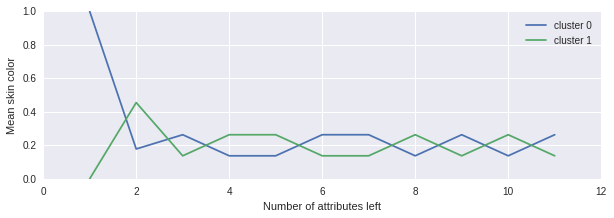

In [50]:
fig,ax = plt.subplots(figsize=(10,3))
plt.plot(range(11,0,-1), mean0[-11:], label='cluster 0')
plt.plot(range(11,0,-1), mean1[-11:], label='cluster 1')
plt.xlabel('Number of attributes left')
plt.ylabel('Mean skin color')
ax.legend()

Note that the inversion between the blue line and the green line are not important since the labels 0 and 1 are given randomly at first (that is cluster 1 could be cluster 0, and inversely). 

We can thus see that the clustering clusters blacks and whites always in the same way until the moment that just 3 features are left. This clustering does not separate very well blacks from whites, since the mean skin color in both clusters are not too far apart. So there is never a clustering that clearly separates whites and blacks, except when just 2 features are left, including the rater's mean value of the skinColor!! The 2nd most relevant attribute is the country in which the club of the player is, especially if he is in the French league. This is not for nothing that the French team is called "les blacks, blancs, beurres"!

Let's thus try to do in the following the same thing as above, but without considering the last attribute of the data, that is without considering 'skinColor'. Since KMeans++ has not been able to determine 2 clear clusters separating blacks and white, we do not expect it to be able to do it without the most relevant attribute, but let's see.

In [51]:
scoresb = []
mean0b = []
mean1b = []
for i in range(0,len(ordered_attributes)-1):
    scoresb.append(
        estimate_data(kmpp,metric_silhouette,'k-means++ euclidean  ',
                      X_test[ordered_attributes[i:-1]], False))
    mean0b.append(y_test[kmpp.labels_==0].mean())
    mean1b.append(y_test[kmpp.labels_==1].mean())

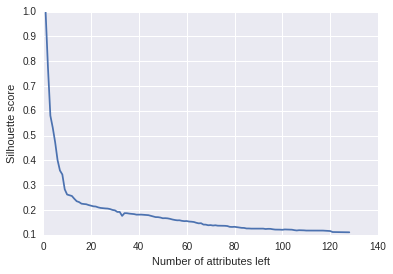

In [52]:
plt.plot(range(len(ordered_attributes)-1,0,-1), scoresb)
plt.xlabel('Number of attributes left')
plt.ylabel('Silhouette score')

On this graph, we can give the same conclusions as on the previous similar graph, when the skin color was also considered. 

We now plot the evolution of the silhouette score with respect to the number of attributes left.

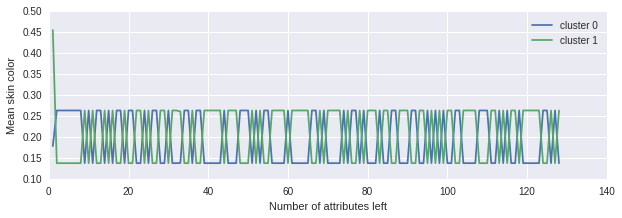

In [53]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(range(len(ordered_attributes)-1,0,-1), mean0b, label='cluster 0')
plt.plot(range(len(ordered_attributes)-1,0,-1), mean1b, label='cluster 1')
plt.xlabel('Number of attributes left')
plt.ylabel('Mean skin color')
ax.legend()

Let's make a zoom on the end of the loop, that is when just few attributes are left.

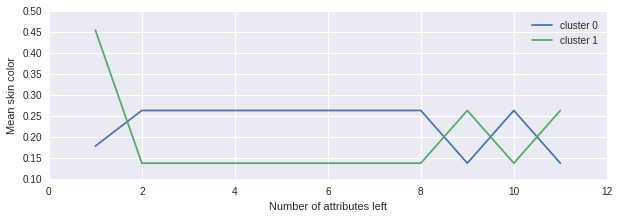

In [54]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(range(11,0,-1), mean0b[-11:], label='cluster 0')
plt.plot(range(11,0,-1), mean1b[-11:], label='cluster 1')
plt.xlabel('Number of attributes left')
plt.ylabel('Mean skin color')
ax.legend()

We can thus see that we cannot conclude anything more than what we have concluded before. The only way to determine a bit better the probability that a player is black or white, is to know if he is in the French league or not!

## Better way to solve the problem
### Supposing we DO NOT have the rater's evaluation of the skin color of the players:

As we have said before, the importance ordering can obviously be controversed, and it influences a lot the clustering. But how can we order the attributes when there is no direct information on the skin color at all?

In this case, at each step, we will perform the clustering on the data set meines an attribute, recursively deleting one attribute from the original data set at this step. To be clearer, let's say that at step number i, there are the attributes 1 to j. We will thus perform j times the KMeans clustering algorithm, recursively on the data set with attributes 2 to j, then 2, and 4 to j, then 2 to 3 and 5 to j, etc, that is on the data set with all the attributes, meines the kth one, for k going from 1 to j, recursively. 

We then analyse the result of all of these clusterings, and for the next step, we choose to remove the attribute that separates better the data into 2 distinct clusters. That is, we choose to remove the attributes that allows to get the higher silhouette score. If there is a tie, we choose to remove the first index presenting this higher silhouette score.

In [55]:
ordered_attributes = ordered_attributes.drop('skinColor')

In [56]:
scores = []
mean0 = []
mean1 = []
for first_idx in range(0,len(train.columns)-2):
    partial_score = 0
    index_best_score = ordered_attributes[0]
    good_labels = []
    len_ordered_attributes = len(ordered_attributes)
    for idx_nb in range(0,len_ordered_attributes):
        actual_data = train[ordered_attributes[[j for j in range(0,len_ordered_attributes) 
                                                  if j!=idx_nb]]]
        actual_score = estimate_data(kmpp,metric_silhouette,'k-means++ euclidean  ',
                                     actual_data, False)
        if actual_score > partial_score:
            index_best_score = ordered_attributes[idx_nb]
            partial_score = actual_score
            good_labels0 = (kmpp.labels_==0)
    scores.append(partial_score)
    ordered_attributes = ordered_attributes.drop(index_best_score)
    mean0.append(labels[good_labels0].mean())
    mean1.append(labels[np.invert(good_labels0)].mean())
    
    if first_idx%20 == 0:
        print(first_idx)

0
20
40
60
80
100
120


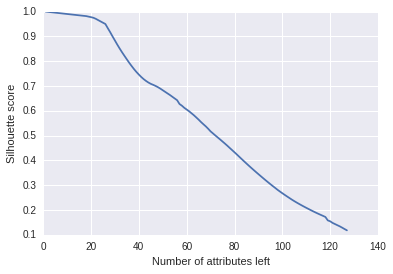

In [57]:
plt.plot(range(len(train.columns)-2,0,-1), scores)
plt.xlabel('Number of attributes left')
plt.ylabel('Silhouette score')

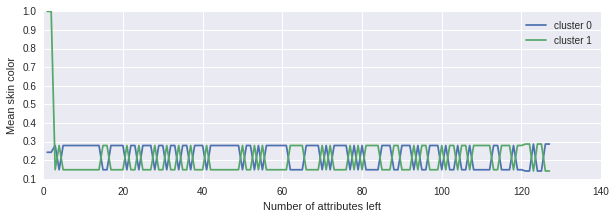

In [58]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(range(len(train.columns)-2,0,-1), mean0, label='cluster 0')
plt.plot(range(len(train.columns)-2,0,-1), mean1, label='cluster 1')
plt.xlabel('Number of attributes left')
plt.ylabel('Mean skin color')
ax.legend()

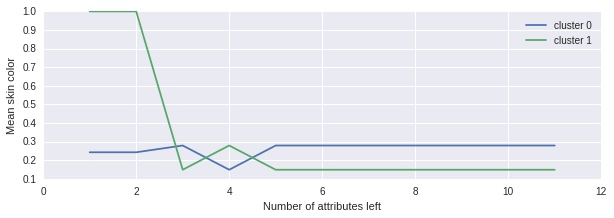

In [59]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(range(11,0,-1), mean0[-11:], label='cluster 0')
plt.plot(range(11,0,-1), mean1[-11:], label='cluster 1')
plt.xlabel('Number of attributes left')
plt.ylabel('Mean skin color')
ax.legend()